In [18]:
import os
import subprocess

from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
from tqdm.auto import tqdm

from radmc3dPy.image import readImage, plotImage, makeImage
from astropy import constants as c

au = c.au.cgs.value
pc = c.pc.cgs.value
M_sun = c.M_sun.cgs.value
L_sun = c.L_sun.cgs.value
R_sun = c.R_sun.cgs.value
Grav = c.G.cgs.value
m_p = c.m_p.cgs.value


def logistic(a, r, r0, dr):
    return np.radians(a / (1.0 + np.exp((r - r0) / (0.1 * dr))))


def grid_refine_inner_edge(x_orig, nlev, nspan):
    x = x_orig.copy()
    rev = x[0] > x[1]
    for ilev in range(nlev):
        x_new = 0.5 * (x[1:nspan + 1] + x[:nspan])
        x_ref = np.hstack((x, x_new))
        x_ref.sort()
        x = x_ref
        if rev:
            x = x[::-1]
    return x

def warp_coordinates(x, y, z, phi, theta):
    xprime = x * np.cos(phi)   - y * np.cos(theta) * np.sin(phi) + z * np.sin(theta) * np.sin(phi)   
    yprime = x * np.sin(phi)   + y * np.cos(theta) * np.cos(phi) - z * np.sin(theta) * np.cos(phi)
    zprime =                     y * np.sin(theta)               + z * np.cos(theta)
    return xprime, yprime, zprime


def unwarp_coordinates(x, y, z, phi, theta):
    xprime =  x * np.cos(phi)                 + y * np.sin(phi)
    yprime = -x * np.sin(phi) * np.cos(theta) + y * np.cos(phi) * np.cos(theta) + z * np.sin(theta)
    zprime =  x * np.sin(phi) * np.sin(theta) - y * np.cos(phi) * np.sin(theta) + z * np.cos(theta)
    return xprime, yprime, zprime

def vel_sph_to_car(theta, phi, vr, vtheta, vphi):
    
    vx = vr * np.sin(theta) * np.cos(phi) + vtheta * np.cos(theta) * np.cos(phi) - vphi * np.sin(theta) * np.sin(phi)
    vy = vr * np.sin(theta) * np.sin(phi) + vtheta * np.cos(theta) * np.sin(phi) + vphi * np.sin(theta) * np.cos(phi)
    vz = vr * np.cos(theta)               - vtheta * np.sin(theta)
    
    return vx, vy, vz

def vel_car_to_sph(theta, phi, vx, vy, vz):
    
    vr = vx*np.sin(theta)*np.cos(phi) + vy*np.sin(theta)*np.sin(phi) + vz*np.cos(theta)
    vt = vx*np.cos(theta)*np.cos(phi) + vy*np.cos(theta)*np.sin(phi) - vz*np.sin(theta)
    vp = -vx*np.sin(phi) + vy*np.cos(phi)
    
    return vr, vt, vp

def vel_car_to_sph_2(x, y, z, vx, vy, vz):
    
    # Velocities
    rho = x**2 + y**2
    r = x**2 + y**2 + z**2 
    
    vr = (x*vx + y*vy + z*vz)/np.sqrt(r)
    vtheta = (-(x*vx + y*vy)*z + (rho)*vz)/(np.sqrt(rho)*(r))
    vphi = (x*vy - y*vx)/(rho)
    return vr, vtheta, vphi

In [19]:
def call_radmc(cmd, verbose=False, total=None):
    """
    Run radmc3d command and show progress bar instead.
    
    cmd : str
        the command to run, e.g. 'radmc3d mctherm'
        
    verbose : bool
        if True, then all output except the photon packges are shown
        if False, just the progress is shown.
        
    total : None | int
        total number of photon packages, if known
    """
    p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, text=True)
    output = []
    
    if 'nphot' in cmd:
        total = int(cmd.split('nphot')[1].split()[1])

    with tqdm(total=total, unit='photons') as pbar:
        for line in p.stdout:
            if 'Photon nr' in line:
                pbar.update(1000)
            elif verbose:
                print(line, end='')
            output += [line]
    rc = p.wait()
    return rc, ''.join(output)

In [20]:
# Monte Carlo parameters
#
nphot_therm = 1000000
nphot_scat = 1000000

In [21]:
# Grid parameters
#
n_r = 128
n_theta = 128
n_phi = 128
r_in = 0.5 * au
r_out = 100 * au
thetaup = 0.1       # Theta grid starting point (0=pole, but singular, so choose >0)

In [22]:
# inner edge grid refinement
nlev_rin = 8
nspan_rin = 3

In [23]:
# Disk parameters
#
sigma_0 = 1e1           # Gas surface density at 1 au [g / cm^2]
d2g = 0.01              # dust-to-gas ratio
gamma_gas = 1.0         # power-law exponent of the surface density
hor_0 = 0.05            # h/r at 1 au
hor_exp = 0.1           # flaring exponent

In [24]:
# Star parameters
#
M_star = 2.4 * M_sun
R_star = 2.4 * R_sun
T_star = 1e4
star_coord = np.array([0., 0., 0.])

In [25]:
# Make the coordinates
#
ri = np.geomspace(r_in, r_out, n_r + 1)
ri = grid_refine_inner_edge(ri, nlev_rin, nspan_rin)   # Refinement at inner edge
thetai = np.linspace(thetaup, np.pi - thetaup, n_theta + 1)
phii = np.linspace(0.0, 2.0 * np.pi, n_phi + 1)
rc = 0.5 * (ri[:-1] + ri[1:])
thetac = 0.5 * (thetai[:-1] + thetai[1:])
phic = 0.5 * (phii[:-1] + phii[1:])
n_r = len(rc)     # Recompute nr, because of refinement at inner edge

In [26]:
# Make the full mesh
#
RC, THETAC, PHIC = np.meshgrid(rc, thetac, phic, indexing='ij')
XC = RC * np.sin(THETAC) * np.cos(PHIC)
YC = RC * np.sin(THETAC) * np.sin(PHIC)
ZC = RC * np.cos(THETAC)

### Make the warped model

In [27]:
# un-warp the coordinates
#
warp  = 30. # PA
twist = 15. # This gives the inc
dr    = 40.
r0    = 20

warp_array  = logistic(warp , rc, r0 * au, dr * au)  # Specify the r0 and dr in AU
twist_array = logistic(twist, rc, r0 * au, dr * au)

XU, YU, ZU = unwarp_coordinates(
    XC, YC, ZC,
    warp_array[:, None, None],
    twist_array[:, None, None])

RU = np.sqrt(XU**2 + YU**2 + ZU**2)
THETAU = np.pi / 2.0 - np.arctan2(ZU, np.sqrt(XU**2 + YU**2))
PHIU = (np.arctan2(YU, XU) + np.pi)%(2 * np.pi)
#print(PHIU.max(), PHIU.min())
#print(THETAU.max(), THETAU.min())

In [28]:
# Make the dust density model
#
sig_g = sigma_0 * (RU / au)**-gamma_gas
H = hor_0 * (RU / au)**hor_exp * RU
rho_g = (sig_g / (np.sqrt(2. * np.pi) * H)) * np.exp(-(ZU**2 / H**2) / 2.0)
rho_d = d2g * rho_g

In [29]:
# Make the gas temperature model
T_0 = 300.
q = 0.5
tgas = T_0 * (RU / (50.0 * au))**(-q)

In [30]:
#XU, YU, ZU = unwarp_coordinates(XW, YW, ZW, warp_array[:, None, None], twist_array[:, None, None])
VRU = np.zeros_like(RU)
VTU = np.zeros_like(RU)
VPU = np.sqrt(Grav * M_star / RU)

# make cartesian velocities

VXU, VYU, VZU = vel_sph_to_car(THETAU, PHIU, VRU, VTU, VPU)

# warp velocities
VXW, VYW, VZW = warp_coordinates(
    VXU, VYU, VZU,
    warp_array[:, None, None],
    twist_array[:, None, None])

# obtain velocities in spherical from the original mesh
#VRW, VTW, VPW = vel_car_to_sph(THETAC, PHIC, VXU, VYU, VZU)
VRW, VTW, VPW = vel_car_to_sph_2(XU, YU, ZU, VXU, VYU, VZU)

vturb = 0.001 * VPW

### Write RADMC3D SETUP

In [31]:
# Write the wavelength_micron.inp file
#
lam1 = 0.1e0
lam2 = 7.0e0
lam3 = 25.0e0
lam4 = 1.0e4
n12 = 20
n23 = 100
n34 = 30
lam12 = np.geomspace(lam1, lam2, n12, endpoint=False)
lam23 = np.geomspace(lam2, lam3, n23, endpoint=False)
lam34 = np.geomspace(lam3, lam4, n34, endpoint=True)
lam = np.concatenate([lam12, lam23, lam34])
nlam = lam.size

In [32]:
# Write the wavelength file
#
with open('wavelength_micron.inp', 'w+') as f:
    f.write('%d\n' % (nlam))
    for value in lam:
        f.write('%13.6e\n' % (value))

In [33]:
# Write the stars.inp file
#
with open('stars.inp', 'w+') as f:
    f.write('2\n')
    f.write('1 %d\n\n' % (nlam))
    f.write('%13.6e %13.6e %13.6e %13.6e %13.6e\n\n' % (R_star, M_star, *star_coord))
    for value in lam:
        f.write('%13.6e\n' % (value))
    f.write('\n%13.6e\n' % (-T_star))

In [34]:
# Write the grid file
#
with open('amr_grid.inp', 'w+') as f:
    f.write('1\n')                       # iformat
    f.write('0\n')                       # AMR grid style  (0=regular grid, no AMR)
    f.write('100\n')                     # Coordinate system: spherical
    f.write('0\n')                       # gridinfo
    f.write('1 1 1\n')                   # Include r,theta coordinates
    f.write('%d %d %d\n' % (n_r, n_theta, n_phi))  # Size of grid
    for value in ri:
        f.write('%13.6e\n' % (value))      # X coordinates (cell walls)
    for value in thetai:
        f.write('%13.6e\n' % (value))      # Y coordinates (cell walls)
    for value in phii:
        f.write('%13.6e\n' % (value))      # Z coordinates (cell walls)

In [35]:
# Write the density file
#
with open('dust_density.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    f.write('1\n')                       # Nr of dust species
    data = rho_d.ravel(order='F')         # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

In [36]:
# Dust opacity control file
#
with open('dustopac.inp', 'w+') as f:
    f.write('2               Format number of this file\n')
    f.write('1               Nr of dust species\n')
    f.write('============================================================================\n')
    f.write('1               Way in which this dust species is read\n')
    f.write('0               0=Thermal grain\n')
    f.write('silicate        Extension of name of dustkappa_***.inp file\n')
    f.write('----------------------------------------------------------------------------\n')

In [37]:
# Write the molecule number density file.
#
CO_abundance = 1e-4
fact_CO = CO_abundance / (2.3 * m_p)
nco = rho_g * fact_CO
with open('numberdens_co.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    data = nco.ravel(order='F')          # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

In [38]:
# Write the gas velocity field
#
with open('gas_velocity.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    for iphi in range(n_phi):
        for itheta in range(n_theta):
            for ir in range(n_r):
                f.write('%13.6e %13.6e %13.6e\n' % (VRW[ir, itheta, iphi], VTW[ir, itheta, iphi], VPW[ir, itheta, iphi]))

In [39]:
# Write the microturbulence file
#
with open('microturbulence.inp', 'w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n' % (n_r * n_theta * n_phi))     # Nr of cells
    data = vturb.ravel(order='F')        # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

In [40]:
# Write the gas temperature file
#
with open('gas_temperature.inp','w+') as f:
    f.write('1\n')                       # Format number
    f.write('%d\n'%(n_r*n_theta*n_phi))           # Nr of cells
    data = tgas.ravel(order='F')          # Create a 1-D view, fortran-style indexing
    data.tofile(f, sep='\n', format="%13.6e")
    f.write('\n')

In [41]:
# Write the lines.inp control file
#
with open('lines.inp', 'w') as f:
    f.write('1\n')
    f.write('1\n')
    f.write('co    leiden    0    0\n')

In [42]:
# Write the radmc3d.inp control file
#
with open('radmc3d.inp', 'w+') as f:
    f.write('nphot = %d\n' % (nphot_therm))
    f.write('nphot_scat = %d\n' % (nphot_scat))
    f.write('scattering_mode_max = 1\n')
    f.write('iranfreqmode = 1\n')
    f.write('tgas_eq_tdust = 0\n')

## Run RADMC-3D

In [43]:
dpc         = 140.     # Distance in parsec (for conversion to Jy/pixel in 1.3 mm map)
incl        = 45.
phi         = 45.
npix        = 200
sizeau      = 200
lamda_image = 1.3e3

### Thermal Monte Carlo

In [44]:
rc, output = call_radmc('radmc3d mctherm setthreads 4', total=nphot_therm)
#os.system('radmc3d mctherm setthreads 4')

  0%|          | 0/1000000 [00:00<?, ?photons/s]

### Check density contours of dust and gas

In [45]:
import matplotlib.pylab as plb
from radmc3dPy import analyze, natconst

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp


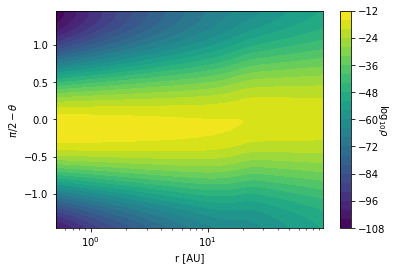

In [51]:
data = analyze.readData(ddens=True, ispec='co')
c = plb.contourf(data.grid.x/natconst.au, np.pi/2.-data.grid.y, np.log10(data.rhodust[:,:,0,0].T), 30)
plb.xlabel('r [AU]')
plb.ylabel(r'$\pi/2-\theta$')
plb.xscale('log')

cb = plb.colorbar(c)
cb.set_label(r'$\log_{10}{\rho}$', rotation=270.)



In [47]:
# Now let's make a set of channel maps
vkms = 0.
rc, output = call_radmc(f'radmc3d image imolspec 1 iline 2 vkms {vkms} incl {incl} phi {phi} npix {npix} setthreads 4 sizeau {sizeau}', total=nphot_scat)
#os.system(f'radmc3d image imolspec 1 iline 2 vkms {vkms} incl {incl} phi {phi} npix {npix} setthreads 4 sizeau {sizeau}')

  0%|          | 0/1000000 [00:00<?, ?photons/s]

Read and plot the image

Reading image.out


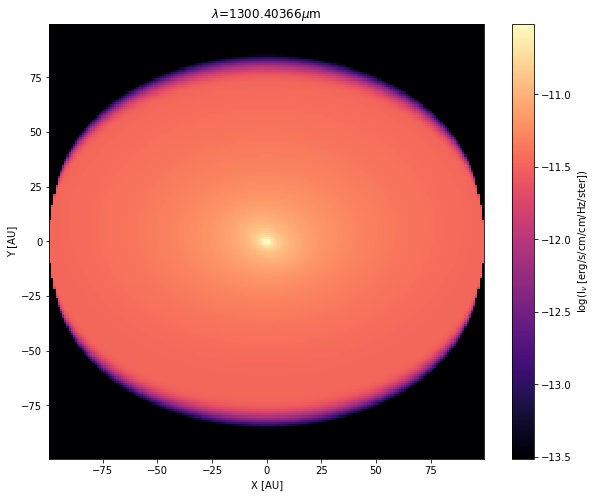

{'implot': <matplotlib.image.AxesImage at 0x7f235e84ab80>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x7f235e84af70>}

In [48]:
im = readImage()
f, ax = plt.subplots(figsize=(10, 8))
plotImage(im, au=True, log=True, maxlog=3, bunit='inu', dpc=dpc, cmap='magma', ax=ax)

(-100.0, 100.0)

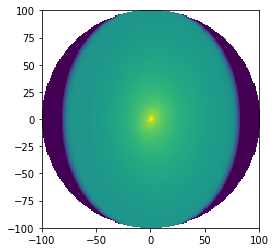

In [49]:
f, ax = plt.subplots()
vmax = im.image.max()
ax.imshow(im.image[:,:,0], norm=LogNorm(vmin=1e-2 * vmax, vmax=vmax), interpolation='none', extent=np.array([-r_out, r_out, -r_out, r_out])/au)
ax.set_xlim(-100,100)
ax.set_ylim(-100,100)

### Try to make momentmaps

In [ ]:
# Create channelmaps in a range of +- 5km/s'
widthkms = 3
linenlam = 10
#os.system(f'radmc3d image iline 2 widthkms {widthkms} linenlam {linenlam} incl {incl} phi {phi} npix {npix} setthreads 4 sizeau {sizeau} nphot_spec {nphot_scat}')
rc, output = call_radmc(f'radmc3d image iline 2 widthkms {widthkms} linenlam {linenlam} incl {incl} phi {phi} npix {npix} setthreads 4 sizeau {sizeau}', total=nphot_scat)

  0%|          | 0/1000000 [00:00<?, ?photons/s]

In [130]:
im = readImage()

# Write fits file
fname=str(f'cube_incl{incl}phi{phi}_inc{warp}_PA{twist}.fits')
nu0 = 230.538*10**9 # Hz
im.writeFits(fname=fname, dpc=dpc, coord='03h10m05s -10d05m30s',
             bandwidthmhz=2000.0, casa=False, nu0=nu0, stokes='I')

Reading image.out


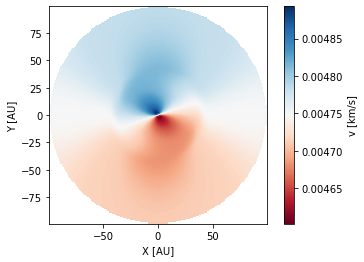

In [131]:
moment = 1
wav0 = lamda_image
vrange = [-1.0, 1.0]
#mmap = im.getMomentMap(moment=1, wav0=wav0)
mmap = im.plotMomentMap(moment=1, wav0=wav0, dpc=dpc, au=True, cmap='RdBu', vclip=vrange)

In [132]:
import bettermoments as bm
data, velax = bm.load_cube(fname)
rms = bm.estimate_RMS(data=data, N=5)
moments = bm.collapse_first(velax=velax, data=data, rms=rms)
bm.save_to_FITS(moments=moments, method='first', path=fname)